In [27]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [28]:
DATA_DIR = '/home/mkeoliya/projects/mc-med/mc-med-1.0.0/data'

In [3]:
visits_df = pd.read_csv(os.path.join(DATA_DIR, 'visits.csv'), usecols=['MRN', 'CSN', 'Arrival_time', 'Departure_time', 'Age', 'Gender', 'Race', 'Ethnicity'])

In [5]:
history_df = pd.read_csv(os.path.join(DATA_DIR, 'pmh.csv'))

In [ ]:
history_visits = visits_df[['MRN', 'CSN', 'Arrival_time', 'Departure_time']]
history_visits = history_df.merge(history_visits, on='MRN', how='left')

In [ ]:
labs_df = pd.read_csv(os.path.join(DATA_DIR, 'labs.csv'))
vitals_df = pd.read_csv(os.path.join(DATA_DIR, 'numerics.csv'))
orders_df = pd.read_csv(os.path.join(DATA_DIR, 'orders.csv'))
rads_df = pd.read_csv(os.path.join(DATA_DIR, 'rads.csv'))

In [ ]:
labs_count = labs_df.groupby('CSN')['Component_name'].count().reset_index(name='Count')
vitals_count = vitals_df.groupby('CSN')['Measure'].count().reset_index(name='Count')
orders_count = orders_df.groupby('CSN')['Procedure_name'].count().reset_index(name='Count')
rads_count = rads_df.groupby('CSN')['Study'].count().reset_index(name='Count')

QUANTILES

In [31]:
df = pd.read_parquet("../data/eventval.parquet")

In [21]:
from tokenizers import Tokenizer, models

vocab_list = list(set().union(*df['eventval']))
special_list = ['[UNK]', '[BOS]', '[EOS]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']
vocab_list = special_list + vocab_list

vocab = {token: idx for idx, token in enumerate(vocab_list)}

# Create a WordLevel tokenizer with the custom vocab and an unknown token
tokenizer = Tokenizer(models.WordLevel(vocab=vocab, unk_token="[UNK]"))

tokenizer.save(os.path.join('../data', f'eventval_tokenizer.json'))

In [3]:
def try_parse_float(x):
    if isinstance(x, str):
        try:
            x = x.lstrip('<>=').strip()
            x = x.replace(',', ':')
            if ':' in x:
                try:
                    num, denom = x.split(':')
                    return float(num) / float(denom)
                except (ValueError, ZeroDivisionError):
                    return x
            return float(x)
        except ValueError:
            return x
    return x

In [4]:
labs_df = pd.read_csv(os.path.join(DATA_DIR, 'labs.csv'), usecols=['CSN', 'Component_name', 'Component_value'])
labs_df = labs_df.dropna()
labs_df['Component_value'] = labs_df['Component_value'].apply(try_parse_float)
labs_df['Component_value'] = labs_df['Component_value'].apply(lambda x: 0.0 if isinstance(x, str) and 'pos' in x.lower() else x)
labs_df['Component_value'] = labs_df['Component_value'].apply(lambda x: 1.0 if isinstance(x, str) and (any(sub in x.lower() for sub in ['neg', 'not', 'none', 'auto'])) else x)

In [6]:
scale = 10_000  # for 4 decimal places

In [7]:
labs = {}
lab_names = labs_df['Component_name'].unique()

for l in lab_names:
    df = labs_df[labs_df['Component_name'] == l]
    bucket = np.percentile(df['Component_value'], np.arange(0, 110, 10))
    bucket = np.array([
            np.floor(bucket[0] * scale) / scale,             # floor first
            *np.round(bucket[1:-1] * scale) / scale,         # round middle
            np.ceil(bucket[-1] * scale) / scale              # ceil last
        ])
    labs[l] = bucket[np.concatenate(([True], bucket[1:] != bucket[:-1]))]

In [8]:
numerics_df = pd.read_csv(os.path.join(DATA_DIR, 'numerics.csv'), usecols=['CSN', 'Measure', 'Value'])
numerics_df = numerics_df.dropna()

In [9]:
numerics = {}
numerics_names = numerics_df['Measure'].unique()

for n in numerics_names:
    df = numerics_df[numerics_df['Measure'] == n]
    bucket = np.percentile(df['Value'], np.arange(0, 110, 10))
    bucket = np.array([
            np.floor(bucket[0] * scale) / scale,             # floor first
            *np.round(bucket[1:-1] * scale) / scale,         # round middle
            np.ceil(bucket[-1] * scale) / scale              # ceil last
        ])
    numerics[n] = bucket[np.concatenate(([True], bucket[1:] != bucket[:-1]))]

In [11]:
with open('labs_buckets.pkl', 'wb') as f:
    pickle.dump(labs, f)

with open('numerics_buckets.pkl', 'wb') as f:
    pickle.dump(numerics, f)

DATA COUNT

In [5]:
N = 5

In [6]:
counts = pd.concat([labs_count, vitals_count, orders_count, rads_count])
counts = counts.groupby('CSN').sum().reset_index().sort_values('Count')
counts = counts[counts['Count'] > N]

In [9]:
counts['values'] = (counts['Count']/10).round().astype(int)

In [23]:
(counts['values'] < 40).sum() / len(counts)

0.5392619812146917

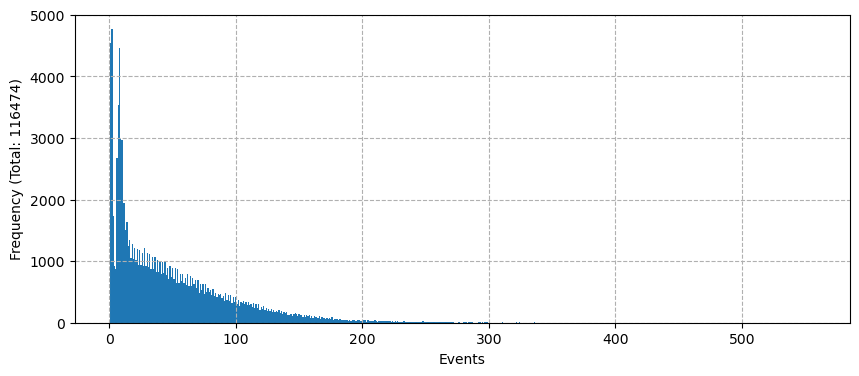

In [15]:
plt.figure(figsize=(10, 4))
plt.hist(counts['values'], bins=range(counts['values'].min(), counts['values'].max() + 2), align='left')
plt.xlabel('Events')
plt.ylabel('Frequency (Total: 116474)')
plt.grid(True, linestyle='--')
plt.show()